In [1]:
import sys
sys.path.append('/g/data1a/e14/as3189/OFAM/scripts/')
import gsw
import numpy as np
import xarray as xr
from scipy import stats
from pathlib import Path
from scipy import interpolate
import matplotlib.pyplot as plt
from main import paths, idx_1d, LAT_DEG, lx
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import LinearSegmentedColormap
# Path to save figures, save data and OFAM model output.
fpath, dpath, xpath, lpath = paths()
tpath = Path('/g', 'data', 'e14', 'as3189', 'OFAM', 'TAO')
lons = [165, 190, 220]

In [2]:
T = 1
freq = ['daily', 'monthy'][T]
freqx = ['day', 'mon'][T]
fx = ['dy', 'mon'][T]
lons = [165, 190, 220]

# Open data sets at each longitude.
dU_165 = xr.open_dataset(tpath.joinpath('adcp0n165e_{}.cdf'.format(fx))).sel(lat=0, lon=165, depth=slice(10, 355))
dU_190 = xr.open_dataset(tpath.joinpath('adcp0n170w_{}.cdf'.format(fx))).sel(lat=0, lon=190, depth=slice(10, 355))
dU_220 = xr.open_dataset(tpath.joinpath('adcp0n140w_{}.cdf'.format(fx))).sel(lat=0, lon=220, depth=slice(10, 355))
# print(dU_165.u_1205)
# print(dU_190.u_1205)
# print(dU_220.u_1205)

missing_value = dU_165.missing_value # 1e35

# Remove empty times?
du_165 = dU_165.where(dU_165['u_1205'] != missing_value)
du_190 = dU_190.where(dU_190['u_1205'] != missing_value)
du_220 = dU_220.where(dU_220['u_1205'] != missing_value)

# Drop empty values.
du_dropped_165 = dU_165.where(du_165['u_1205'] != missing_value, drop=True)
du_dropped_190 = dU_190.where(du_190['u_1205'] != missing_value, drop=True)
du_dropped_220 = dU_220.where(du_220['u_1205'] != missing_value, drop=True)
data = [du_165, du_190, du_220]
ds = [du_165, du_190, du_220]

# Plot multiple subplots

In [3]:
def plot_tao(fig, z, t, u, i, name, max_depth=355, rows=1):
    cmap = plt.cm.seismic
    cmap.set_bad('lightgrey') 
    ax = fig.add_subplot(rows, 3, i)
    ax.set_title(name, loc='left')
    im = ax.pcolormesh(t, z, u, cmap=cmap, vmax=120, vmin=-120)
    ax.set_ylim(max_depth, 10)
    if rows == 1 or (rows == 2 and i >= 4):
        if rows == 1:
            plt.colorbar(im, shrink=1, orientation='horizontal', extend='both')
        else:
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            plt.colorbar(axes[0][0], cax=cbar_ax, shrink=1, orientation='horizontal', extend='both')
    if i == 1 or i == 4:
        ax.set_ylabel('Depth [m]')
    #Add separate colourbar axes (left, bottom, width, height)
    return ax

In [ ]:
fig = plt.figure(figsize=(18, 6))
for i in range(3):
    lon = lons[i]
    du = ds[i]
    name = '{}TAO/TRITION EUC at {}°E ({})'.format(lx['l'][i], lon, freq)
    
    z = du.depth
    t = du.time 
    u = du.u_1205.transpose('depth', 'time')
    plot_tao(fig, z, t, u, i+1, name)
save_name = 'tao_original_{}.png'.format(freqx)
plt.savefig(fpath.joinpath('tao', save_name))
plt.show()

In [ ]:
fig = plt.figure(figsize=(18, 6))
for i in range(3):
    lon = lons[i]
    du = ds[i]
    name = '{}TAO/TRITION EUC at {}°E ({}, linear)'.format(lx['l'][i], lon, freq)
    t = du.depth.values
    z = np.arange(len(du.time))
    u = du.u_1205.values
    u_mask = np.ma.masked_invalid(u)
    tt, zz = np.meshgrid(t, z)
    t1 = tt[~u_mask.mask]
    z1 = zz[~u_mask.mask]
    u_masked = u_mask[~u_mask.mask]
    gn = interpolate.griddata((t1, z1), u_masked.ravel(),(tt, zz), method='linear')
    plot_tao(fig, t, du.time, np.transpose(gn), i+1, name)
save_name = 'tao_linear_{}.png'.format(freqx)
plt.savefig(fpath.joinpath('tao', save_name))
plt.show()

In [ ]:
fig = plt.figure(figsize=(18, 6))
for i in range(3):
    lon = lons[i]
    du = ds[i]
    name = '{}TAO/TRITION EUC at {}°E ({}, nearest)'.format(lx['l'][i], lon, freq)
    t = du.depth.values
    z = np.arange(len(du.time))
    u = du.u_1205.values
    u_mask = np.ma.masked_invalid(u)
    tt, zz = np.meshgrid(t, z)
    t1 = tt[~u_mask.mask]
    z1 = zz[~u_mask.mask]
    u_masked = u_mask[~u_mask.mask]
    gn = interpolate.griddata((t1, z1), u_masked.ravel(),(tt, zz), method='nearest')
    plot_tao(fig, du.depth, du.time, np.transpose(gn), i+1, name)
save_name = 'tao_nearest_{}.png'.format(freqx)
plt.savefig(fpath.joinpath('tao', save_name))
plt.show()

In [ ]:
fig = plt.figure(figsize=(18, 6))
for i in range(3):
    lon = lons[i]
    du = ds[i]
    name = '{}TAO/TRITION EUC at {}°E ({}, linear -10)'.format(lx['l'][i], lon, freq)
    t = du.depth.values
    z = np.arange(len(du.time))
    du.u_1205[:, -1] = -10
    for n in range(len(du.u_1205[:, 0])):
        if np.isnan(du.u_1205[n, 0]):
            du.u_1205[n, 0] = 0 
    u = du.u_1205.values
    u_mask = np.ma.masked_invalid(u)
    tt, zz = np.meshgrid(t, z)
    t1 = tt[~u_mask.mask]
    z1 = zz[~u_mask.mask]
    u_masked = u_mask[~u_mask.mask]
    gn = interpolate.griddata((t1, z1), u_masked.ravel(),(tt, zz), method='linear')
    plot_tao(fig, du.depth, du.time, np.transpose(gn), i+1, name)
save_name = 'tao_linear-10_{}.png'.format(freqx)
plt.savefig(fpath.joinpath('tao', save_name))
plt.show()

# Finding max velocity at each time ste

In [16]:
T = 1
freq = ['daily', 'monthy'][T]
freqx = ['day', 'mon'][T]
fx = ['dy', 'mon'][T]

# Open data sets at each longitude.
dU_165 = xr.open_dataset(tpath.joinpath('adcp0n165e_{}.cdf'.format(fx))).sel(lat=0, lon=165, depth=slice(10, 355))
dU_190 = xr.open_dataset(tpath.joinpath('adcp0n170w_{}.cdf'.format(fx))).sel(lat=0, lon=190, depth=slice(10, 355))
dU_220 = xr.open_dataset(tpath.joinpath('adcp0n140w_{}.cdf'.format(fx))).sel(lat=0, lon=220, depth=slice(10, 355))

missing_value = 1e35#dU_165.missing_value # 1e35

# Remove empty times?np.ma.masked_invalid(du)
# du_165 = np.ma.masked_invalid(dU_165.where(dU_165['u_1205'] < missing_value).u_1205)/100
# du_190 = np.ma.masked_invalid(dU_190.where(dU_190['u_1205'] < missing_value).u_1205)/100
# du_220 = np.ma.masked_invalid(dU_220.where(dU_220['u_1205'] < missing_value).u_1205)/100
du_165 = dU_165.where(dU_165['u_1205'] < missing_value).u_1205/100
du_190 = dU_190.where(dU_190['u_1205'] < missing_value).u_1205/100
du_220 = dU_220.where(dU_220['u_1205'] < missing_value).u_1205/100
data = [du_165, du_190, du_220]
ds = [du_165, du_190, du_220]

In [5]:
du_190 = dU_190.fillna(dU_190['u_1205'] != missing_value)
# np.isnan(du_190.u_1205[-8*12, 0])

In [6]:
np.isnan(du_190.u_1205[-8*12]).all()

<xarray.DataArray 'u_1205' ()>
array(False)
Coordinates:
    time     datetime64[ns] 2008-09-16T12:00:00
    lat      float32 0.0
    lon      float32 190.0

# Regression: Max velocity and bottom depth

In [7]:
def lower_depths(du, i, min_v=0.05, eps=0.025, index=True):
    u = np.ma.masked_invalid(du)
    amx = np.nanargmax(u, axis=1)
    umx = np.nanmax(u, axis=1)
    amx = np.ma.masked_where(amx == 0, amx)
    amn = amx.copy()*np.nan
    depths = amx.copy()*np.nan
    idepths = amx.copy()*np.nan
    count = 0
    empty = 0
    for t in range(du.shape[0]):
        # Make sure entire slice isn't all empty.
        if not (u[t] == True).mask.all() and not np.ma.is_masked(amx[t]):

            # Find deepest velocity depth index.
            end = np.ma.nonzero(u[t])[-1][-1]
            # Search from the lowest depth to the location of max velocity depth.
            for z in np.arange(end, amx[t], -1):
                # Make sure the end value isn't too much larger than v_min.
                if u[t, z] >= min_v + eps and z == end:
                    break
                # Find the depth index where velocity starts to be larger than v_min.
                if u[t, z] >= min_v:
                    # Find the velocity is closest to v_min (in the subset array).
                    tmp = u[t, idx_1d(u[t, z-1:], min_v) + z-1]
                    # Find the depth index of the cloest velocity (in the full array).
                    amn[t] = np.argwhere(u[t] == tmp)[-1][-1]
                    # Find that depth.
                    depths[t] = du.depth[int(amn[t])]
                    count += 1
                    break
        else:
            empty += 1
    print('{}: Min velocity={}, included={}, total={}, skipped={}, Empty={}, eps={}'
          .format(lons[i], min_v, count, du.shape[0], du.shape[0] - count - empty,  empty, eps))
    if index == False:
        return umx, depths
    else:
        return umx, amn

def max_depths(du, i):
    u = np.ma.masked_invalid(du)
    amx = np.nanargmax(u, axis=1)
    umx = np.nanmax(u, axis=1)
    amx = np.ma.masked_where(amx == 0, amx)
    amn = amx.copy()*np.nan
    depths = amx.copy()*np.nan

    for t in range(du.shape[0]):
        if not (u[t] == True).mask.all() and not np.ma.is_masked(amx[t]):
            depths[t] = du.depth[int(amx[t])].item()

    return umx, depths

def cor_scatter_plot(fig, i, umx, depths, name=None):
    var0 = umx[np.ma.nonzero(depths)]
    var1 = depths[np.ma.nonzero(depths)]
    var0 = var0[~np.isnan(var1)]
    var1 = var1[~np.isnan(var1)]
    cor = stats.spearmanr(var0, var1)
    print(cor)
    slope, intercept, r_value, p_value, std_err = stats.linregress(var0, var1)
    print('slope={:.2f}, intercept={:.2f}, r_value={:.2f}, p_value={:.2f}, std_err={:.2f}'
          .format(slope, intercept, r_value, p_value, std_err))
    
    ax = fig.add_subplot(1, 3, i)
    ax.set_title(name, loc='left')
    ax.scatter(umx, depths, color='b', s=8)

    atext = AnchoredText('$\mathregular{r_s}$=' + str(np.around(cor[0], 2)) + 
                         ', p=' + str(np.around(cor[1], 3)), loc=3)
    ax.add_artist(atext)
    ax.plot(np.unique(var0), np.poly1d(np.polyfit(var0, var1, 1)) (np.unique(var0)), 'k')
    line = slope*var0+intercept
    plt.plot(var0, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope, intercept))
    ax.set_xlabel('Max velocity [cm/s]')
    ax.set_ylabel('Bottom depth [m]')
    ax.legend(fontsize=9)
    return 

SpearmanrResult(correlation=-0.28599480924697046, pvalue=4.621138121023163e-05)
slope=-68.07, intercept=211.54, r_value=-0.20, p_value=0.00, std_err=23.90
SpearmanrResult(correlation=-0.5075804180040542, pvalue=2.6003670264624397e-21)
slope=-52.85, intercept=186.74, r_value=-0.38, p_value=0.00, std_err=7.37
SpearmanrResult(correlation=-0.5950102727143469, pvalue=3.3193904871149367e-28)
slope=-46.89, intercept=160.57, r_value=-0.58, p_value=0.00, std_err=3.92


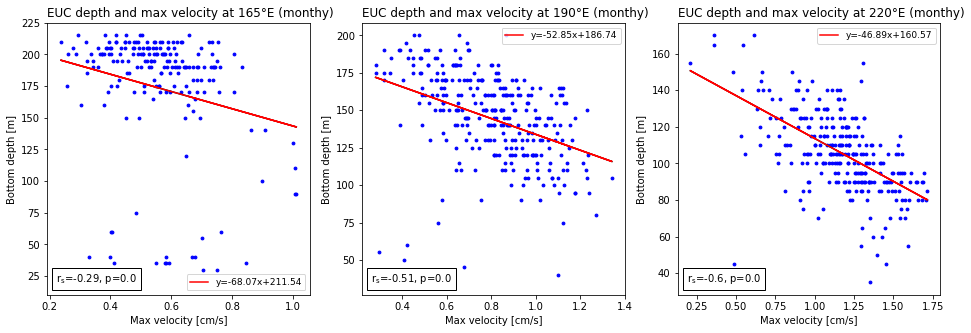

In [16]:
fig = plt.figure(figsize=(16, 5))
for i, du in enumerate([du_165, du_190, du_220]):
    umx, depths = max_depths(du, i)
    name = 'EUC depth and max velocity at {}°E ({})'.format(lons[i], freq)
    cor_scatter_plot(fig, i+1, umx, depths, name=name)
plt.savefig(fpath.joinpath('tao', 'max_velocity_max_depth_cor_{}.png'.format(freqx)))

165: Min velocity=0.05, included=47, total=203, skipped=150, Empty=6, eps=0.02
SpearmanrResult(correlation=0.3421231286099863, pvalue=0.018580589704765654)
slope=54.35, intercept=238.97, r_value=0.32, p_value=0.03, std_err=24.34
190: Min velocity=0.05, included=147, total=340, skipped=157, Empty=36, eps=0.02
SpearmanrResult(correlation=0.23373090094868781, pvalue=0.004382665738585978)
slope=26.31, intercept=238.34, r_value=0.28, p_value=0.00, std_err=7.63
220: Min velocity=0.05, included=160, total=311, skipped=120, Empty=31, eps=0.02
SpearmanrResult(correlation=0.26655459137674686, pvalue=0.0006565740323734514)
slope=18.02, intercept=224.41, r_value=0.30, p_value=0.00, std_err=4.49


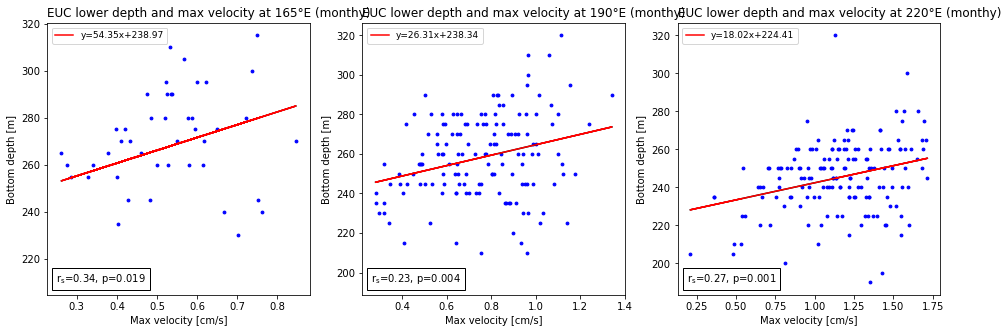

In [459]:
fig = plt.figure(figsize=(16, 5))
for i, du in enumerate([du_165, du_190, du_220]):
    umx, depths = lower_depths(du, i)
    name = 'EUC lower depth and max velocity at {}°E ({})'.format(lons[i], freq)
    cor_scatter_plot(fig, i+1, umx, depths, name=name)
plt.savefig(fpath.joinpath('tao', 'max_velocity_lower_depth_cor_{}.png'.format(freqx)))

165: Min velocity=0.1, included=86, total=203, skipped=111, Empty=6, eps=0.05
190: Min velocity=0.1, included=200, total=340, skipped=104, Empty=36, eps=0.05
220: Min velocity=0.1, included=232, total=311, skipped=48, Empty=31, eps=0.05


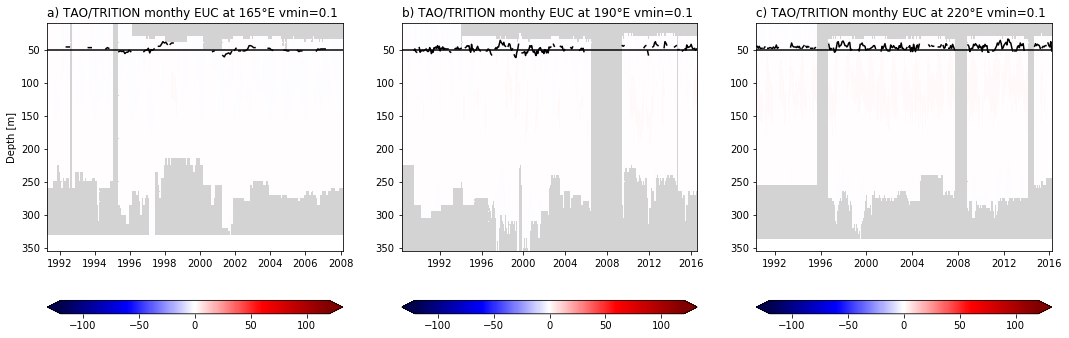

In [25]:
min_v = 0.1 # m/s
eps = np.round(min_v/2, 3)
fig = plt.figure(figsize=(18, 6))
for i in range(3):
    lon = lons[i]
    du = [du_165, du_190, du_220][i]
    name = '{}TAO/TRITION {} EUC at {}°E vmin={}'.format(lx['l'][i], freq, lon, min_v)
    z = du.depth
    t = du.time 
    u = du.transpose('depth', 'time')*100
    ax = plot_tao(fig, z, t, u, i+1, name)
    umx, depths = lower_depths(du, i, min_v=min_v, eps=eps)
    ax.plot(t, depths, 'k')
    ax.axhline(50, color='k')
save_name = 'tao_original_depths_{}_bounds_{}.png'.format(freqx, min_v)
plt.savefig(fpath.joinpath('tao', save_name))
plt.show()

165: Min velocity=0.01, included=28, total=203, skipped=169, Empty=6, eps=0.005
190: Min velocity=0.01, included=107, total=340, skipped=197, Empty=36, eps=0.005
220: Min velocity=0.01, included=109, total=311, skipped=171, Empty=31, eps=0.005

165: Min velocity=0.05, included=51, total=203, skipped=146, Empty=6, eps=0.025
190: Min velocity=0.05, included=153, total=340, skipped=151, Empty=36, eps=0.025
220: Min velocity=0.05, included=167, total=311, skipped=113, Empty=31, eps=0.025

165: Min velocity=0.075, included=67, total=203, skipped=130, Empty=6, eps=0.038
190: Min velocity=0.075, included=182, total=340, skipped=122, Empty=36, eps=0.038
220: Min velocity=0.075, included=196, total=311, skipped=84, Empty=31, eps=0.038

165: Min velocity=0.1, included=86, total=203, skipped=111, Empty=6, eps=0.05
190: Min velocity=0.1, included=200, total=340, skipped=104, Empty=36, eps=0.05
220: Min velocity=0.1, included=232, total=311, skipped=48, Empty=31, eps=0.05

# Interpolating OFAM3 depth to every 5 m


In [ ]:
du = du_190.u_1205
t = -1
y = du[t].values
x = du[t].depth.values

f = interpolate.interp1d(x, y, kind='slinear')
z = np.arange(10, x[-1]+1, 5)
f(z)

In [3]:
files = []
for y in range(lx['years'][0][0], lx['years'][0][1]+1):
    for m in range(1, 13):
        files.append(str(xpath.joinpath('ocean_u_{}_{:02d}.nc'.format(y, m))))

In [368]:
ds = xr.open_mfdataset(files, combine='by_coords')

<xarray.Dataset>
Dimensions:         (Time: 11688, nv: 2, st_edges_ocean: 52, st_ocean: 51, xu_ocean: 1750, yu_ocean: 300)
Coordinates:
  * st_ocean        (st_ocean) float64 2.5 7.5 12.5 ... 3.603e+03 4.509e+03
  * yu_ocean        (yu_ocean) float64 -15.0 -14.9 -14.8 ... 14.7 14.8 14.9
  * nv              (nv) float64 1.0 2.0
  * xu_ocean        (xu_ocean) float64 120.0 120.1 120.2 ... 294.7 294.8 294.9
  * st_edges_ocean  (st_edges_ocean) float64 0.0 5.0 10.0 ... 4.056e+03 5e+03
  * Time            (Time) object 1981-01-01 12:00:00 ... 2012-12-31 12:00:00
Data variables:
    Time_bounds     (Time, nv) timedelta64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    average_DT      (Time) timedelta64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_T1      (Time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    average_T2      (Time) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
    u               (Time, st_ocean, yu_ocean, xu_ocean) float32

In [369]:
ds.st_ocean

<xarray.DataArray 'st_ocean' (st_ocean: 51)>
array([   2.5     ,    7.5     ,   12.5     ,   17.51539 ,   22.667021,
         28.16938 ,   34.218006,   40.954975,   48.454975,   56.718006,
         65.66938 ,   75.167023,   85.015388,   95.      ,  105.      ,
        115.      ,  125.      ,  135.      ,  145.      ,  155.      ,
        165.      ,  175.      ,  185.      ,  195.      ,  205.189896,
        217.054489,  233.194321,  255.884232,  286.608978,  325.884216,
        373.194336,  427.054474,  485.189911,  545.511108,  610.415649,
        685.926758,  775.926758,  880.415649,  995.511108, 1115.313354,
       1238.353882, 1368.157471, 1507.733887, 1658.157471, 1818.353882,
       1985.313354, 2165.180176, 2431.101074, 2894.841797, 3603.101074,
       4509.180176])
Coordinates:
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:      

In [22]:
ds = ds.sel(xu_ocean=[165, 190, 220], yu_ocean=slice(-2.6, 2.6), st_ocean=slice(2.5, 485))
# Calculate the monthly mean.
df = ds.resample(Time="MS").mean()
# New depth levels to interpolate to.
z = np.arange(10, 360, 5)


In [23]:
di = df.interp(st_ocean=z, method='slinear')
# di = df.interp(st_ocean=z, method='cubic')

In [21]:
# # Test to chack interpolation depths.
# t = 0
print(df.u[0].sel(xu_ocean=190.,st_ocean=slice(185, 373.194336))[:, 26].values)
print(di.u[0].sel(xu_ocean=190.,st_ocean=slice(10, 355))[:, 26].values)

[0.46271968 0.46586996 0.45597607 0.43525302 0.39988112 0.34530216
 0.27098468 0.1903272  0.135768  ]
[-0.60045663 -0.58711087 -0.57451055 -0.56089287 -0.54670889 -0.5327543
 -0.52091785 -0.51206265 -0.5045967  -0.49866349 -0.491622   -0.48400037
 -0.47147061 -0.4581822  -0.44004657 -0.42174343 -0.3951818  -0.36859468
 -0.33427121 -0.29994774 -0.25206812 -0.2041885  -0.12318155 -0.0421746
  0.0514483   0.14507121  0.19037151  0.2356718   0.27720649  0.31874117
  0.35463491  0.39052865  0.41509114  0.43965364  0.45118666  0.46271968
  0.46429482  0.46586996  0.46101521  0.45616045  0.4475746   0.43884145
  0.42879767  0.41783972  0.40688177  0.39553769  0.38351055  0.37148341
  0.35945626  0.34742912  0.33534688  0.32325281  0.31115873  0.29906465
  0.28697058  0.2748765   0.26402072  0.25375248  0.24348425  0.23321601
  0.22294777  0.21267954  0.2024113   0.19214307  0.18558077  0.17981465
  0.17404853  0.1682824   0.16251628  0.15675015]


In [24]:
# Slice before inter
print(di.u[0].sel(xu_ocean=190.,st_ocean=slice(10, 355))[:, 26].values)

[        nan -0.58711087 -0.57451055 -0.56089287 -0.54670889 -0.5327543
 -0.52091785 -0.51206265 -0.5045967  -0.49866349 -0.491622   -0.48400037
 -0.47147061 -0.4581822  -0.44004657 -0.42174343 -0.3951818  -0.36859468
 -0.33427121 -0.29994774 -0.25206812 -0.2041885  -0.12318155 -0.0421746
  0.0514483   0.14507121  0.19037151  0.2356718   0.27720649  0.31874117
  0.35463491  0.39052865  0.41509114  0.43965364  0.45118666  0.46271968
  0.46429482  0.46586996  0.46101521  0.45616045  0.4475746   0.43884145
  0.42879767  0.41783972  0.40688177  0.39553769  0.38351055  0.37148341
  0.35945626  0.34742912  0.33534688  0.32325281  0.31115873  0.29906465
  0.28697058  0.2748765   0.26402072  0.25375248  0.24348425  0.23321601
  0.22294777  0.21267954  0.2024113   0.19214307         nan         nan
         nan         nan         nan         nan]


# Calculating transport

In [11]:
# Area = metres in a degree of latitude x cell width x cell depth
area = LAT_DEG*0.1*5

# Multiply each grid cell by the constant.
dt = (di*area).sum(dim='yu_ocean').u.sel(st_ocean=slice(10, 355))
dt

# Plot OFAM3 EUC velocity at the equator

In [8]:
dt = xr.open_dataset(dpath.joinpath('ofam_ocean_u_EUC_int_transport.nc'))
dt

<xarray.Dataset>
Dimensions:   (Time: 384, st_ocean: 70, xu_ocean: 3)
Coordinates:
  * Time      (Time) datetime64[ns] 1981-01-01 1981-02-01 ... 2012-12-01
  * xu_ocean  (xu_ocean) float64 165.0 190.0 220.0
  * st_ocean  (st_ocean) int64 10 15 20 25 30 35 40 ... 330 335 340 345 350 355
    yu_ocean  float64 ...
Data variables:
    uvo       (Time, st_ocean, xu_ocean) float32 ...
    u         (Time, st_ocean, xu_ocean) float32 ...

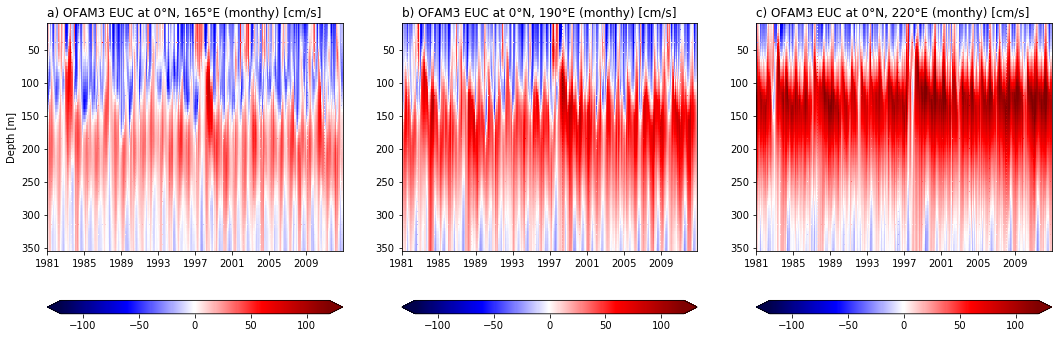

In [438]:
fig = plt.figure(figsize=(18, 6))
for i in range(3):
    lon = lons[i]
    dq = dt.sel(xu_ocean=lon)
    name = '{}OFAM3 EUC at 0°N, {}°E ({}) [cm/s]'.format(lx['l'][i], lon, freq)
    z = dq.st_ocean
    t = dq.Time 
    u = dq.u.transpose('st_ocean', 'Time')*100
    plot_tao(fig, z, t, u, i+1, name, max_depth=355)
save_name = 'ofam3_interp.png'
plt.savefig(fpath.joinpath('tao', save_name))
plt.show()

In [430]:
len(np.ma.getdata(depths))
dt

<xarray.Dataset>
Dimensions:   (Time: 384, st_ocean: 70, xu_ocean: 3)
Coordinates:
  * Time      (Time) datetime64[ns] 1981-01-01 1981-02-01 ... 2012-12-01
  * xu_ocean  (xu_ocean) float64 165.0 190.0 220.0
  * st_ocean  (st_ocean) int64 10 15 20 25 30 35 40 ... 330 335 340 345 350 355
    yu_ocean  float64 ...
Data variables:
    uvo       (Time, st_ocean, xu_ocean) float32 ...
    u         (Time, st_ocean, xu_ocean) float32 ...

# Calculate OFAM3 transport

In [6]:
def EUC_depths(u, i, min_v=0.05, eps=0.005):
    amx = np.argmax(u, axis=1)
    umx = np.max(u, axis=1)
    amn = amx.copy()*np.nan
    mx_depth = amx.copy()*np.nan
    mn_depth = amx.copy()*np.nan
    count = 0
    # Find deepest velocity depth index.
    end = len(dt.st_ocean) -1
    for t in range(u.shape[0]):
        # Find depth of maximum velocity.
        mx_depth[t] = u.st_ocean[int(amx[t])].item()
        
        for z in np.arange(end, amx[t], -1):
            # Make sure the end value isn't too much larger than v_min.
            if u[t, z] >= min_v + eps and z == end:
                break
            # Find the depth index where velocity starts to be larger than v_min.
            if u[t, z] >= min_v:
                # Find the velocity is closest to v_min (in the subset array).
                tmp = u[t, idx_1d(u[t, z-1:], min_v) + z-1].item()
                # Find the depth index of the cloest velocity (in the full array).
                amn[t] = np.argwhere(u[t].values == tmp)[-1][-1]
                # Find that depth.
                mn_depth[t] = u.st_ocean[int(amn[t])]
                count += 1
                break
    print('{}E: Min velocity={}, included={}, total={}, skipped={}, eps={}'
          .format(lons[i], min_v, count, u.shape[0], u.shape[0] - count, eps))

    return umx, mx_depth, mn_depth

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


165E: Min velocity=0.1, included=362, total=384, skipped=22, eps=0.05
190E: Min velocity=0.1, included=334, total=384, skipped=50, eps=0.05
220E: Min velocity=0.1, included=360, total=384, skipped=24, eps=0.05


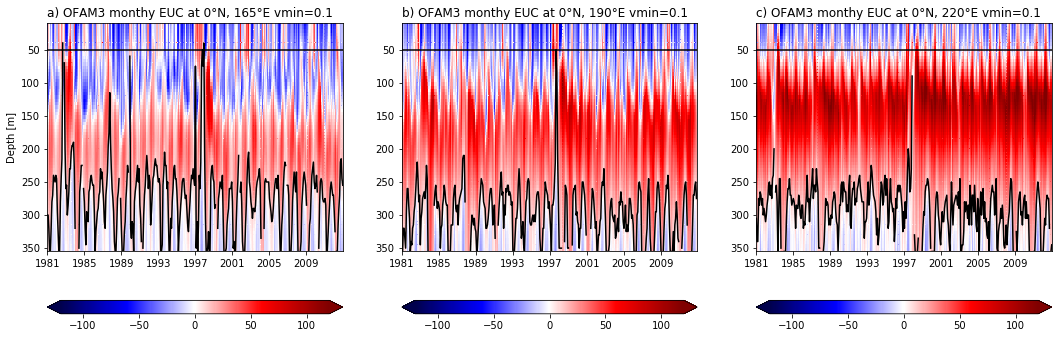

In [9]:
min_v = 0.1 # m/s
eps = np.round(min_v/2, 3)
fig = plt.figure(figsize=(18, 6))
for i in range(3):
    lon = lons[i]
    dq = dt.sel(xu_ocean=lon)
    name = '{}OFAM3 {} EUC at 0°N, {}°E vmin={}'.format(lx['l'][i], freq, lon, min_v)
    z = dq.st_ocean
    t = dq.Time 
    u = dq.u.transpose('st_ocean', 'Time')*100
    ax = plot_tao(fig, z, t, u, i+1, name, max_depth=355)
    umx, mx_depth, mn_depth = EUC_depths(dq.u, i, min_v=min_v, eps=eps)
    ax.plot(t, mn_depth, 'k')
    ax.axhline(50, color='k')
save_name = 'ofam3_interp_bounds_{}.png'.format(min_v)
plt.savefig(fpath.joinpath('tao', save_name))
plt.show()

165: Min velocity=0.01, included=232, total=384, skipped=152, eps=0.005
190: Min velocity=0.01, included=188, total=384, skipped=196, eps=0.005
220: Min velocity=0.01, included=224, total=384, skipped=160, eps=0.005

165: Min velocity=0.05, included=301, total=384, skipped=83, eps=0.025
190: Min velocity=0.05, included=264, total=384, skipped=120, eps=0.025
220: Min velocity=0.05, included=296, total=384, skipped=88, eps=0.025

165: Min velocity=0.1, included=362, total=384, skipped=22, eps=0.05
190: Min velocity=0.1, included=334, total=384, skipped=50, eps=0.05
220: Min velocity=0.1, included=360, total=384, skipped=24, eps=0.05

# Comparing OFAM3 with TAO plots

In [15]:
time_bnds_ofam = [[10*12+3, 27*12+1], [7*12+4, -1], [9*12+4, -1]]
time_bnds_tao = [[0, -1], [0, 24*12+8], [0, 22*12+8]]
print(2014-1990)
for i, du in enumerate([du_165, du_190, du_220]):
    du = du.isel(time=slice(time_bnds_tao[i][0], time_bnds_tao[i][1]))
    ti = du.time[0]
    tf = du.time[-1]
    print(lons[i], ti, tf)
#     print(du.time[24*12+7])
# print(dt.Time[9*12+4])
# [1991-04-16, 2008-02-15] 
# [1988-05-16, 2016-08-16]
# [1990-05-16, 2016-03-16]

24
165 <xarray.DataArray 'time' ()>
array('1991-04-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1991-04-16T12:00:00
    lat      float32 0.0
    lon      float32 165.0
Attributes:
    FORTRAN_format:  
    type:            UNEVEN
    point_spacing:   uneven <xarray.DataArray 'time' ()>
array('2008-01-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2008-01-16T12:00:00
    lat      float32 0.0
    lon      float32 165.0
Attributes:
    FORTRAN_format:  
    type:            UNEVEN
    point_spacing:   uneven
190 <xarray.DataArray 'time' ()>
array('1988-05-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1988-05-16T12:00:00
    lat      float32 0.0
    lon      float32 190.0
Attributes:
    FORTRAN_format:  
    type:            UNEVEN
    point_spacing:   uneven <xarray.DataArray 'time' ()>
array('2012-12-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:

In [21]:
def plot_tao(fig, z, t, u, i, name, max_depth=325, rows=1):
    cmap = plt.cm.seismic
    cmap.set_bad('lightgrey') 
    ax = fig.add_subplot(rows, 3, i)
    ax.set_title(name, loc='left')
    im = ax.pcolormesh(t, z, u, cmap=cmap, vmax=1.20, vmin=-1.20)
    ax.set_ylim(max_depth, 10)
    
    if rows == 1:
        plt.colorbar(im, shrink=1, orientation='horizontal', extend='both')
    elif rows == 2 and i == 6:
        cbar_ax = fig.add_axes([0.33, 0.05, 0.33, 0.03])
        cbar = plt.colorbar(im, cax=cbar_ax, shrink=1, orientation='horizontal', extend='both')
        cbar.set_label('Zonal velocity [m/s]')
    if i == 1 or i == 4:
        ax.set_ylabel('Depth [m]')
    #Add separate colourbar axes (left, bottom, width, height)
    return ax

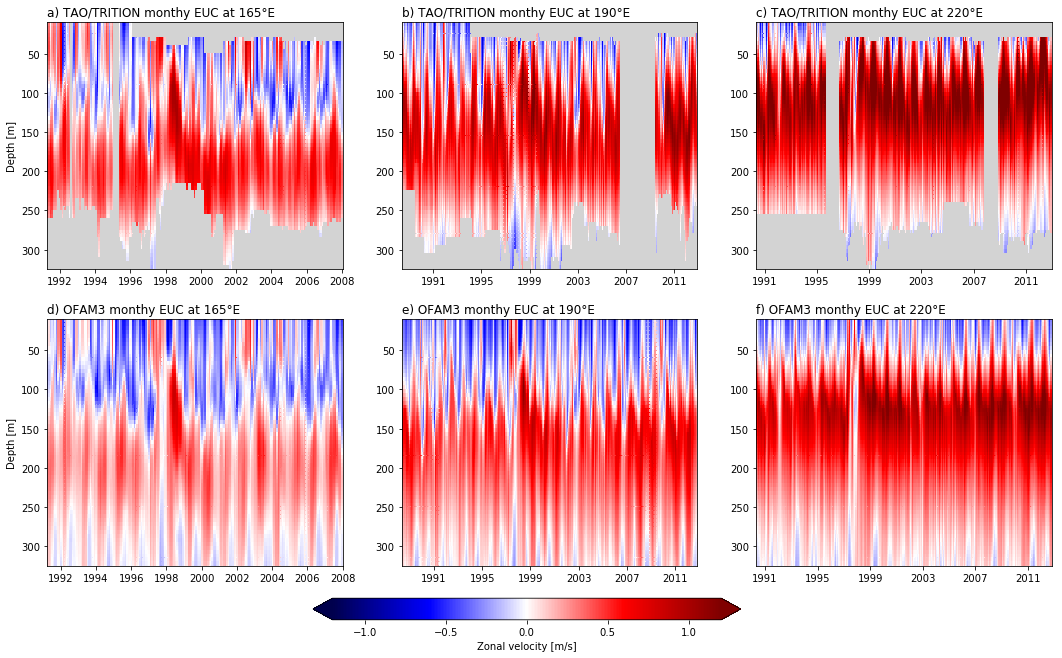

In [22]:
min_v = 0.1 # m/s
eps = np.round(min_v/2, 3)
fig = plt.figure(figsize=(18, 10))

for i, lon in enumerate(lons):
    du = [du_165, du_190, du_220][i]
    du = du.isel(time=slice(time_bnds_tao[i][0], time_bnds_tao[i][1]))
    name = '{}TAO/TRITION {} EUC at {}°E'.format(lx['l'][i], freq, lon)
    z = du.depth
    t = du.time 
    u = du.transpose('depth', 'time')
    ax = plot_tao(fig, z, t, u, i+1, name, rows=2)
#     umx, depths = lower_depths(du, i, min_v=min_v, eps=eps)
#     ax.plot(t, depths, 'k')
#     ax.axhline(50, color='k')
    
for i, lon in enumerate(lons):
    dq = dt.sel(xu_ocean=lon)
    dq = dq.isel(Time=slice(time_bnds_ofam[i][0], time_bnds_ofam[i][1]))
    name = '{}OFAM3 {} EUC at {}°E '.format(lx['l'][i+3], freq, lon)
    z = dq.st_ocean
    t = dq.Time 
    u = dq.u.transpose('st_ocean', 'Time')
    ax = plot_tao(fig, z, t, u, i+4, name, rows=2)
#     umx, mx_depth, mn_depth = EUC_depths(dq.u, i, min_v=min_v, eps=eps)
#     ax.plot(t, mn_depth, 'k')
#     ax.axhline(50, color='k')

save_name = 'tao_ofam_depths_{}_bounds_{}.png'.format(freqx, min_v)
plt.savefig(fpath.joinpath('tao', save_name))
plt.show()

In [627]:
min_v = 0.1 # m/s
eps = np.round(min_v/2, 3)

for i, lon in enumerate(lons):
    du = [du_165, du_190, du_220][i]
    lon=lons[i]
    du = du.isel(time=slice(time_bnds_tao[i][0], time_bnds_tao[i][1])).sel(depth=slice(50, 355))
    umx, depths = lower_depths(du, i, min_v=min_v, eps=eps, index=True)
    tmp = np.ma.where(np.isnan(depths) == False)[0]
    xp = du.sel(depth=50).copy()*np.nan
    xp_165 = xp.copy()
    xp_190 = xp.copy()
    xp_220 = xp.copy()
    for t in tmp:
        r = du[t, 0:int(depths[t])+1]*5
        r = r.where(r > 0, 0)
        xp[t] = np.sum(r).item()
    if i == 0:
        xp_165 = xp
    elif i == 1:
        xp_190 = xp
    elif i == 2:
        xp_220 = xp

165: Min velocity=0.1, included=74, total=202, skipped=107, Empty=21, eps=0.05
190: Min velocity=0.1, included=167, total=296, skipped=88, Empty=41, eps=0.05
220: Min velocity=0.1, included=200, total=272, skipped=43, Empty=29, eps=0.05


In [619]:

t=15636501 
print(depths[t], du.depth[t].item(), du[t, int(depths[t])].item())
r = du[t, 0:int(depths[t])+1]*5
r = r.where(r > 0, 0)
np.sum(r).item()

41.0 125.0 0.08906452357769012


84.93547821044922

In [626]:
xp*230*1000/1e6

<xarray.DataArray 'u_1205' (time: 296)>
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 24.04854  ,
       19.53516  , 22.334856 , 22.086304 ,        nan,        nan,
        5.3279314,  7.802441 , 10.47663  , 18.80938  , 23.878302 ,
       31.664022 , 29.151312 , 19.522327 , 15.455922 , 17.53414  ,
       18.130404 , 10.892059 ,  5.434436 , 10.715124 , 24.181532 ,
       24.1427   , 28.36451  , 19.023281 , 23.589392 , 17.431252 ,
       12.172214 ,  6.5705805,        nan, 10.84821  , 10.390587 ,
       10.881854 , 14.510607 , 16.015322 , 24.42754  , 22.541744 ,
       25.633165 , 21.182425 , 20.113651 , 15.146779 ,        nan,
       12.418961 ,  9.779358 ,        nan,        nan, 17.315077 ,
              nan, 21.203625 , 19.801292 , 20.027351 ,  9.334474 ,
       15.518783 , 12.924306 , 15.432197 , 11.831008 ,        nan,
              nan,    